In [1]:
from threshold_regression import *

from adios2toolspy import SuperCell, BpParticles, BpFields
from h5toolspy import H5Processor
from picplot import fieldGrid, histGrid
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [16, 8]

In [2]:
root = '/mnt/lustre/germaschewski/jca32/psc/build/smallRun2/'
dt = 0.175009  
dx= 0.25 #dx/de 
dy, dz = 4, 0.25 # dy/de, dz/de 

In [3]:
def averaging(arr):
    x, y = arr.shape
    arr = np.pad(arr, ((1,1), (1,1)))
    temp = np.zeros((x,y))
    for i in range(x):
        for j in range(y):
            temp[i,j] = (arr[i,j] + arr[i+1,j] + arr[i-1,j] + arr[i,j+1] + arr[i,j-1] + arr[i-1,j-1] + arr[i-1,j+1] + arr[i+1,j-1] + arr[i+1,j+1])/9
    return temp

def fc_to_nc(x, dim='x'):
    h, w = x.shape
    tmp = np.zeros((h,w))
    if dim == 'x':
        tmp[1:,:] = 0.5*(x[:-1,:] + x[1:,:])
    elif dim == 'y':
        tmp[1:,1:] = 0.25*(x[1:,1:] + x[:-1,1:] + x[1:,:-1] + x[:-1,:-1])
    else: #'z'
        tmp[:,1:] = 0.5*(x[:,:-1] + x[:,1:])

    return tmp

def ec_to_nc(x, dim='x'):
    h, w = x.shape
    tmp = np.zeros((h,w))
    if dim == 'x':
        tmp[:,1:] = 0.5*(x[:,1:] + x[:,:-1])
    if dim == 'y':
        return x
    else: # z
        tmp[1:,:] = 0.5*(x[1:,:] + x[:-1,:])
    return tmp

In [4]:
h5p = H5Processor(root, timeAveraged=False)
time = 29
tstep = 1
cutx, cutz = 200, 125

prep = lambda x, t: averaging(h5p.getH5Grid(x, t).data[:,0,:])[cutz:-cutz, cutx:-cutx].flatten()


bx = h5p.getH5Grid('hx_fc', time).data[:,0,:]
by = h5p.getH5Grid('hy_fc', time).data[:,0,:]
bz = h5p.getH5Grid('hz_fc', time).data[:,0,:]

Bx = averaging(fc_to_nc(bx, dim='x'))[cutz:-cutz,cutx:-cutx].flatten()
By = averaging(fc_to_nc(by, dim='y'))[cutz:-cutz,cutx:-cutx].flatten()
Bz = averaging(fc_to_nc(bz, dim='z'))[cutz:-cutz,cutx:-cutx].flatten()

n = -prep('rho_nc_e', time)
px = prep('px_nc_e', time)
py = prep('py_nc_e', time)
pz = prep('pz_nc_e', time)
pxx = prep('txx_nc_e', time)
pxy = prep('txy_nc_e', time)
pxz = prep('tzx_nc_e', time)
pyy = prep('tyy_nc_e', time)
pyz = prep('tyz_nc_e', time)
pzz = prep('tzz_nc_e', time)

jx = prep('jx_nc_e', time)
jy = prep('jy_nc_e', time)
jz = prep('jz_nc_e', time)
ex = h5p.getH5Grid('ex_ec', time).data[:,0,:]
ey = h5p.getH5Grid('ey_ec', time).data[:,0,:]
ez = h5p.getH5Grid('ez_ec', time).data[:,0,:]
Ex = averaging(ec_to_nc(ex, dim='x'))[cutz:-cutz,cutx:-cutx].flatten()
Ey = averaging(ec_to_nc(ey, dim='y'))[cutz:-cutz,cutx:-cutx].flatten()
Ez = averaging(ec_to_nc(ez, dim='z'))[cutz:-cutz,cutx:-cutx].flatten()

zshape, xshape = bz.shape
zshape -= 2*cutz
xshape -= 2*cutx

Loading hx_fc from File: pfd.002549.xdmf
Loading hy_fc from File: pfd.002549.xdmf
Loading hz_fc from File: pfd.002549.xdmf
Loading rho_nc_e from File: pfd.002549.xdmf
Loading px_nc_e from File: pfd.002549.xdmf
Loading py_nc_e from File: pfd.002549.xdmf
Loading pz_nc_e from File: pfd.002549.xdmf
Loading txx_nc_e from File: pfd.002549.xdmf
Loading txy_nc_e from File: pfd.002549.xdmf
Loading tzx_nc_e from File: pfd.002549.xdmf
Loading tyy_nc_e from File: pfd.002549.xdmf
Loading tyz_nc_e from File: pfd.002549.xdmf
Loading tzz_nc_e from File: pfd.002549.xdmf
Loading jx_nc_e from File: pfd.002549.xdmf
Loading jy_nc_e from File: pfd.002549.xdmf
Loading jz_nc_e from File: pfd.002549.xdmf
Loading ex_ec from File: pfd.002549.xdmf
Loading ey_ec from File: pfd.002549.xdmf
Loading ez_ec from File: pfd.002549.xdmf


In [5]:
b_norm = np.sqrt(Bx**2 + By**2 + Bz**2)
b_x = Bx/b_norm
b_y = By/b_norm
b_z = Bz/b_norm

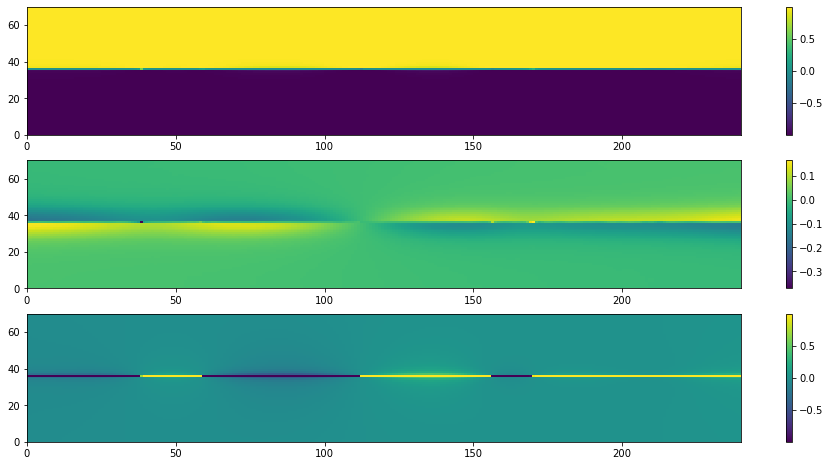

In [6]:
fig, axes = plt.subplots(3,1)
pcm0 = axes[0].pcolormesh(b_x.reshape(zshape, xshape))
pcm1 = axes[1].pcolormesh(b_y.reshape(zshape, xshape))
pcm2 = axes[2].pcolormesh(b_z.reshape(zshape, xshape))
fig.colorbar(pcm0, ax=axes[0])
fig.colorbar(pcm1, ax=axes[1])
fig.colorbar(pcm2, ax=axes[2])

In [7]:
B_par = np.vstack((b_x, b_y, b_z)).T

In [8]:
#Gram-Schmidt orthoganlization with random vector. third is from cross product
bshape_m, bshape_n = B_par.shape
# v1 = np.random.randn(bshape_m, bshape_n)
v1 = np.zeros((bshape_m, bshape_n))
# v1[:,0] = 1
v1[:,1] = 1
# v1[:,2] = 1
# B_perp1 = v1 - np.sum(v1*B_par, -1).reshape(-1,1)*B_par
B_perp1 = np.cross(B_par, v1)
B_perp1 /= np.linalg.norm(B_perp1, axis=-1).reshape(-1,1)
B_perp2 = np.cross(B_par, B_perp1)
B_perp2 /= np.linalg.norm(B_perp2, axis=-1).reshape(-1,1)

In [9]:
#orthogonal check
np.sum(B_perp1*B_par), np.sum(B_perp2*B_par), np.sum(B_perp1*B_perp2)

(1.0408340855860843e-16, -7.922265274351581e-16, -1.7730771278284818e-16)

In [10]:
#normalized check
np.linalg.norm(B_par, axis=-1).sum()/B_par.shape[0], np.linalg.norm(B_perp1, axis=-1).sum()/B_perp1.shape[0], np.linalg.norm(B_perp2, axis=-1).sum()/B_perp2.shape[0]

(1.0, 1.0, 1.0)

In [11]:
B_matrix = np.stack((B_par, B_perp1, B_perp2), -1)
B_matrix.shape

(16800, 3, 3)

In [12]:
#centered Pii
Pxx_c = (pxx - n*px*px)
Pyy_c = (pyy - n*py*py) 
Pzz_c = (pzz - n*pz*pz)
Pxy_c = (pxy - n*px*py)
Pxz_c = (pxz - n*px*pz)
Pyz_c = (pyz - n*py*pz)
P_matrix_x = np.stack((Pxx_c, Pxy_c, Pxz_c), -1)
P_matrix_y = np.stack((Pxy_c, Pyy_c, Pyz_c), -1)
P_matrix_z = np.stack((Pxz_c, Pyz_c, Pzz_c), -1)
P_avg = 1/3*(Pxx_c + Pyy_c + Pzz_c).reshape(zshape, xshape)

# uncentered Pii
# P_matrix_x = np.stack((pxx, pxy, pxz), -1)
# P_matrix_y = np.stack((pxy, pyy, pyz), -1)
# P_matrix_z = np.stack((pxz, pyz, pzz), -1)
# P_avg = 1/3*(pxx + pyy + pzz).reshape(zshape, xshape)

P_matrix = np.stack((P_matrix_x, P_matrix_y, P_matrix_z), -1)
P_matrix_img = P_matrix.reshape(zshape,xshape,3,3)

In [13]:
#unitary check
np.allclose(np.eye(3), (np.transpose(B_matrix, (0,2,1))@B_matrix))

True

In [14]:
P_rotated = np.transpose(B_matrix, (0,2,1))@P_matrix@B_matrix

In [15]:
P_rotated_img = P_rotated.reshape(zshape,xshape,3,3)

3.8683636130198007e-16

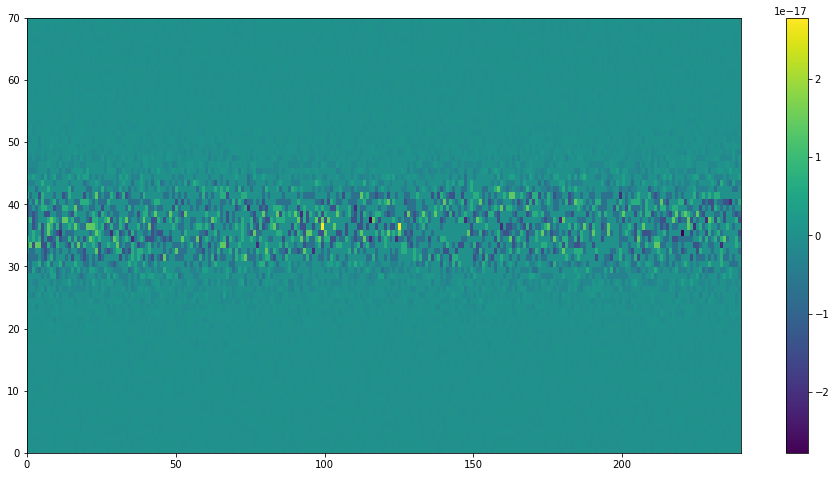

In [16]:
## check that trace of rotated equals original Pressure 
plt.pcolormesh((P_matrix[:,0,0] + P_matrix[:,1,1] + P_matrix[:,2,2]).reshape(zshape,xshape) - (P_rotated[:,0,0] + P_rotated[:,1,1] + P_rotated[:,2,2]).reshape(zshape,xshape))
plt.colorbar()
np.linalg.norm((P_matrix[:,0,0] + P_matrix[:,1,1] + P_matrix[:,2,2]) - (P_rotated[:,0,0] + P_rotated[:,1,1] + P_rotated[:,2,2]))

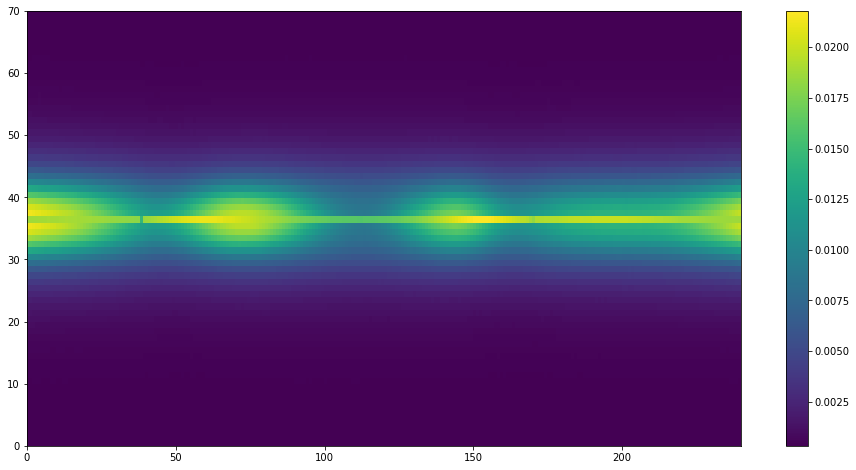

In [17]:
#p_par
plt.pcolormesh(P_rotated_img[..., 0,0])
plt.colorbar()

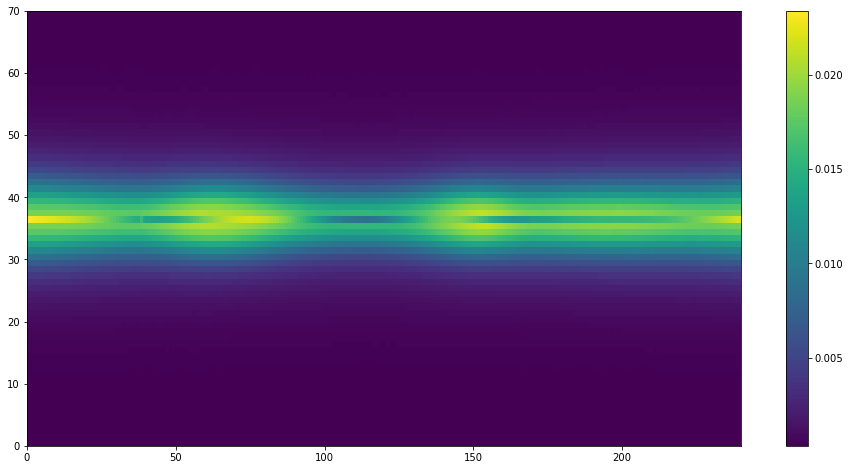

In [18]:
#p_perp1
plt.pcolormesh(P_rotated_img[..., 1,1])
plt.colorbar()

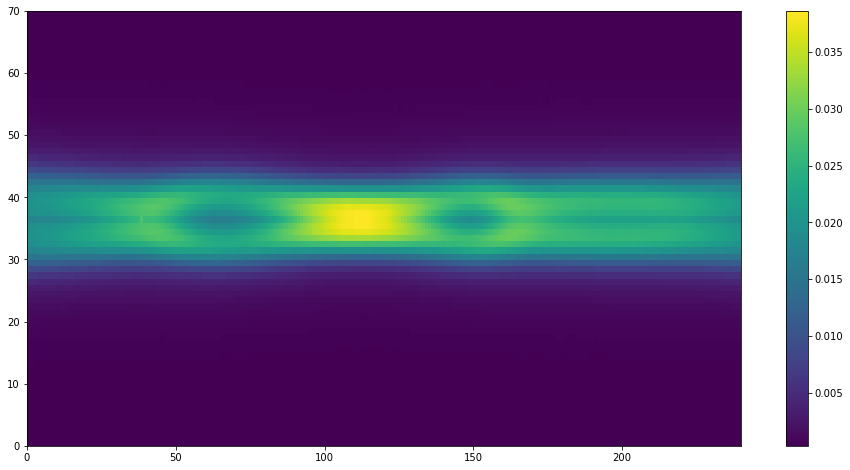

In [19]:
#p_perp2
plt.pcolormesh(P_rotated_img[..., 2,2])
plt.colorbar()

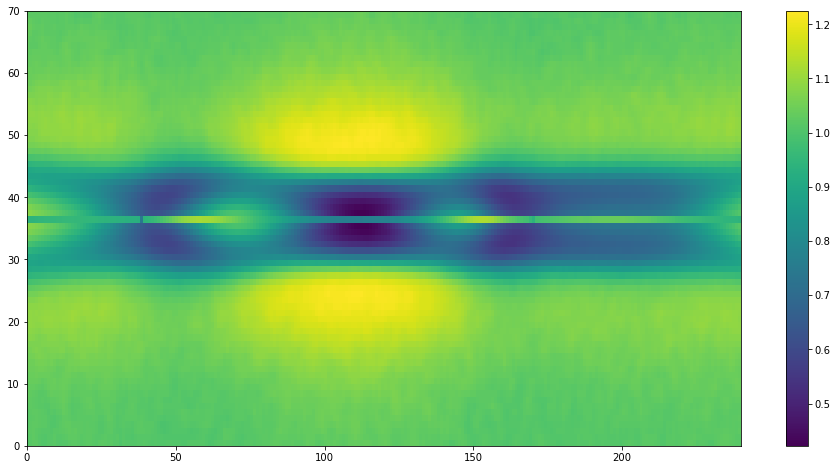

In [20]:
#anisotropy ratio
plt.pcolormesh(P_rotated_img[..., 0,0]/P_avg)
plt.colorbar()

In [21]:
#Swisdak 2016 off diagonal check, Eqn #5
(P_rotated[:,0,1]**2 < P_rotated[:,0,0]*P_rotated[:,1,1]).all(), (P_rotated[:,0,2]**2 < P_rotated[:,0,0]*P_rotated[:,1,1]).all(),(P_rotated[:,1,2]**2 < P_rotated[:,1,1]*P_rotated[:,1,1]).all()

(True, True, True)

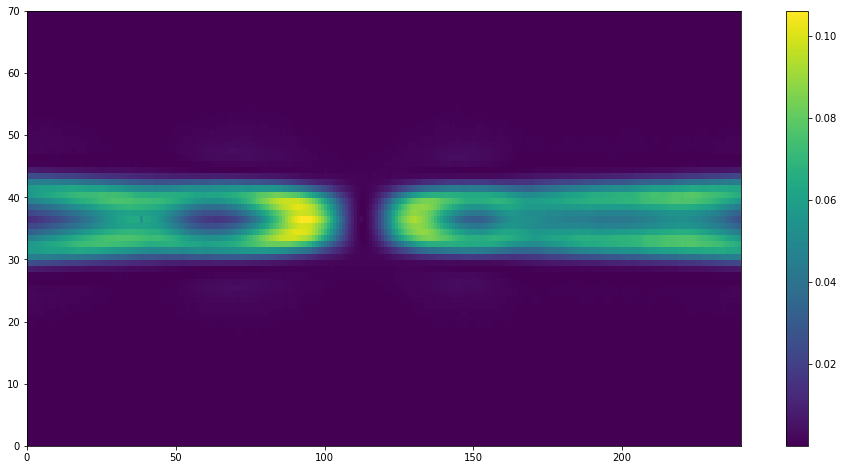

In [22]:
Q = (P_rotated[:,0,1]**2 + P_rotated[:,0,2]**2 + P_rotated[:,1,2]**2) / (P_rotated[:,0,0]**2 + 2*P_rotated[:,1,1]*P_rotated[:,0,0])
plt.pcolormesh(Q.reshape(zshape,xshape))
plt.colorbar()

In [23]:
qxxx = averaging(h5p.getH5Grid('qxxx_nc_e', time).data[:,0,:])
qxxz = averaging(h5p.getH5Grid('qxxz_nc_e', time).data[:,0,:])
qyyx = averaging(h5p.getH5Grid('qyyx_nc_e', time).data[:,0,:])
qyyz = averaging(h5p.getH5Grid('qyyz_nc_e', time).data[:,0,:])
qzzx = averaging(h5p.getH5Grid('qzzx_nc_e', time).data[:,0,:])
qzzz = averaging(h5p.getH5Grid('qzzz_nc_e', time).data[:,0,:])
qxyx = averaging(h5p.getH5Grid('qxxy_nc_e', time).data[:,0,:])
qxyz = averaging(h5p.getH5Grid('qxyz_nc_e', time).data[:,0,:])
qxzx = qxxz
qxzz = qzzx
qyzx = qxyz
qyzz = averaging(h5p.getH5Grid('qzzy_nc_e', time).data[:,0,:])


Loading qxxx_nc_e from File: pfd.002549.xdmf
Loading qxxz_nc_e from File: pfd.002549.xdmf
Loading qyyx_nc_e from File: pfd.002549.xdmf
Loading qyyz_nc_e from File: pfd.002549.xdmf
Loading qzzx_nc_e from File: pfd.002549.xdmf
Loading qzzz_nc_e from File: pfd.002549.xdmf
Loading qxxy_nc_e from File: pfd.002549.xdmf
Loading qxyz_nc_e from File: pfd.002549.xdmf
Loading qzzy_nc_e from File: pfd.002549.xdmf


In [24]:
### Closure calculations done with the centered moment quantities, which is what c stands for
c_prep = lambda x, t: averaging(h5p.getH5Grid(x, t).data[:,0,:])
n_c =  -c_prep('rho_nc_e', time)
px_c = c_prep('px_nc_e', time)
py_c = c_prep('py_nc_e', time)
pz_c = c_prep('pz_nc_e', time)
pyy_c = c_prep('tyy_nc_e', time)
pxx_c = c_prep('txx_nc_e', time)
pxy_c =  c_prep('txy_nc_e', time)
pxz_c = c_prep('tzx_nc_e', time)
pzz_c = c_prep('tzz_nc_e', time)
pyz_c =  c_prep('tyz_nc_e', time)


qxxx_c = qxxx + 2*n_c*px_c*px_c*px_c - 3*px_c*pxx_c
qxxz_c = qxxz + 2*n_c*px_c*px_c*pz_c - 2*px_c*pxz_c - pz_c*pxx_c

qyyx_c = qyyx + 2*n_c*py_c*py_c*px_c - 2*py_c*pxy_c - px_c*pyy_c
qyyz_c = qyyz + 2*n_c*py_c*py_c*pz_c - 2*py_c*pyz_c - pz_c*pyy_c

qzzx_c = qxxz + 2*n_c*pz_c*pz_c*px_c - 2*pz_c*pxz_c - px_c*pzz_c
qzzz_c = qzzz + 2*n_c*pz_c*pz_c*pz_c - 3*pz_c*pzz_c

qxyx_c = qxyx + 2*n_c*px_c*py_c*px_c - 2*px_c*pxy_c - py_c*pxx_c
qxyz_c = qxyx + 2*n_c*px_c*py_c*pz_c - px_c*pyz_c - py_c*pxz_c - pz_c*pxy_c

qxzx_c = qxzx + 2*n_c*px_c*pz_c*px_c - 2*px_c*pxz_c - pz_c*pxx_c
qxzz_c = qxzz + 2*n_c*px_c*pz_c*pz_c - 2*pz_c*pxz_c - px_c*pzz_c

qyzx_c = qyzx + 2*n_c*py_c*pz_c*px_c - px_c*pyz_c - py_c*pxz_c - pz_c*pxy_c
qyzz_c = qyzz + 2*n_c*py_c*pz_c*pz_c - 2*pz_c*pyz_c - py_c*pzz_c

d_qxxx_c_dx = (np.diff(qxxx_c, axis=1, append=0) + np.diff(qxxx_c, axis=1, append=0)) / dx / 2
d_qxxz_c_dz = (np.diff(qxxz_c, axis=0, append=0) + np.diff(qxxz_c, axis=0, append=0)) / dz / 2
div_qxx = (d_qxxx_c_dx + d_qxxz_c_dz)[cutz:-cutz,cutx:-cutx]

d_qyyx_c_dx = (np.diff(qyyx_c, axis=1, prepend=0) + np.diff(qyyx_c, axis=1, append=0)) / dx / 2
d_qyyz_c_dz = (np.diff(qyyz_c, axis=0, prepend=0) + np.diff(qyyz_c, axis=0, append=0)) / dz / 2
div_qyy = (d_qyyx_c_dx + d_qyyz_c_dz)[cutz:-cutz,cutx:-cutx]

d_qzzx_c_dx = (np.diff(qzzx_c, axis=1, prepend=0) + np.diff(qzzx_c, axis=1, append=0)) / dx / 2
d_qzzz_c_dz = (np.diff(qzzz_c, axis=0, prepend=0) + np.diff(qzzz_c, axis=0, append=0)) / dz / 2
div_qzz = (d_qzzx_c_dx + d_qzzz_c_dz)[cutz:-cutz,cutx:-cutx]

d_qxyx_c_dx = (np.diff(qxyx_c, axis=1, prepend=0) + np.diff(qxyx_c, axis=1, append=0)) / dx / 2
d_qxyz_c_dz = (np.diff(qxyz_c, axis=0, prepend=0) + np.diff(qxyz_c, axis=0, append=0)) / dz / 2
div_qxy = (d_qxyx_c_dx + d_qxyz_c_dz)[cutz:-cutz,cutx:-cutx]

d_qxzx_c_dx = (np.diff(qxzx_c, axis=1, prepend=0) + np.diff(qxzx_c, axis=1, append=0)) / dx / 2
d_qxzz_c_dz = (np.diff(qxzz_c, axis=0, prepend=0) + np.diff(qxzz_c, axis=0, append=0)) / dz / 2
div_qxz = (d_qxzx_c_dx + d_qxzz_c_dz)[cutz:-cutz,cutx:-cutx]

d_qyzx_c_dx = (np.diff(qyzx_c, axis=1, prepend=0) + np.diff(qyzx_c, axis=1, append=0)) / dx / 2
d_qyzz_c_dz = (np.diff(qyzz_c, axis=0, prepend=0) + np.diff(qyzz_c, axis=0, append=0)) / dz / 2
div_qyz = (d_qyzx_c_dx + d_qyzz_c_dz)[cutz:-cutz,cutx:-cutx]

vt = 0.14

Loading rho_nc_e from File: pfd.002549.xdmf
Loading px_nc_e from File: pfd.002549.xdmf
Loading py_nc_e from File: pfd.002549.xdmf
Loading pz_nc_e from File: pfd.002549.xdmf
Loading tyy_nc_e from File: pfd.002549.xdmf
Loading txx_nc_e from File: pfd.002549.xdmf
Loading txy_nc_e from File: pfd.002549.xdmf
Loading tzx_nc_e from File: pfd.002549.xdmf
Loading tzz_nc_e from File: pfd.002549.xdmf
Loading tyz_nc_e from File: pfd.002549.xdmf


In [25]:
## not centered moments
# d_qxxx_dx = (np.diff(qxxx, axis=1, append=0) + np.diff(qxxx, axis=1, append=0)) / dx / 2
# d_qxxz_dz = (np.diff(qxxz, axis=0, append=0) + np.diff(qxxz, axis=0, append=0)) / dz / 2
# div_qxx = (d_qxxx_dx + d_qxxz_dz)[cut:-cut,cut:-cut]

# d_qyyx_dx = (np.diff(qyyx, axis=1, prepend=0) + np.diff(qyyx, axis=1, append=0)) / dx / 2
# d_qyyz_dz = (np.diff(qyyz, axis=0, prepend=0) + np.diff(qyyz, axis=0, append=0)) / dz / 2
# div_qyy = (d_qyyx_dx + d_qyyz_dz)[cut:-cut,cut:-cut]

# d_qzzx_dx = (np.diff(qzzx, axis=1, prepend=0) + np.diff(qzzx, axis=1, append=0)) / dx / 2
# d_qzzz_dz = (np.diff(qzzz, axis=0, prepend=0) + np.diff(qzzz, axis=0, append=0)) / dz / 2
# div_qzz = (d_qzzx_dx + d_qzzz_dz)[cut:-cut,cut:-cut]

# d_qxyx_dx = (np.diff(qxyx, axis=1, prepend=0) + np.diff(qxyx, axis=1, append=0)) / dx / 2
# d_qxyz_dz = (np.diff(qxyz, axis=0, prepend=0) + np.diff(qxyz, axis=0, append=0)) / dz / 2
# div_qxy = (d_qxyx_dx + d_qxyz_dz)[cut:-cut,cut:-cut]

# d_qxzx_dx = (np.diff(qxzx, axis=1, prepend=0) + np.diff(qxzx, axis=1, append=0)) / dx / 2
# d_qxzz_dz = (np.diff(qxzz, axis=0, prepend=0) + np.diff(qxzz, axis=0, append=0)) / dz / 2
# div_qxz = (d_qxzx_dx + d_qxzz_dz)[cut:-cut,cut:-cut]

# d_qyzx_dx = (np.diff(qyzx, axis=1, prepend=0) + np.diff(qyzx, axis=1, append=0)) / dx / 2
# d_qyzz_dz = (np.diff(qyzz, axis=0, prepend=0) + np.diff(qyzz, axis=0, append=0)) / dz / 2
# div_qyz = (d_qyzx_dx + d_qyzz_dz)[cut:-cut,cut:-cut]



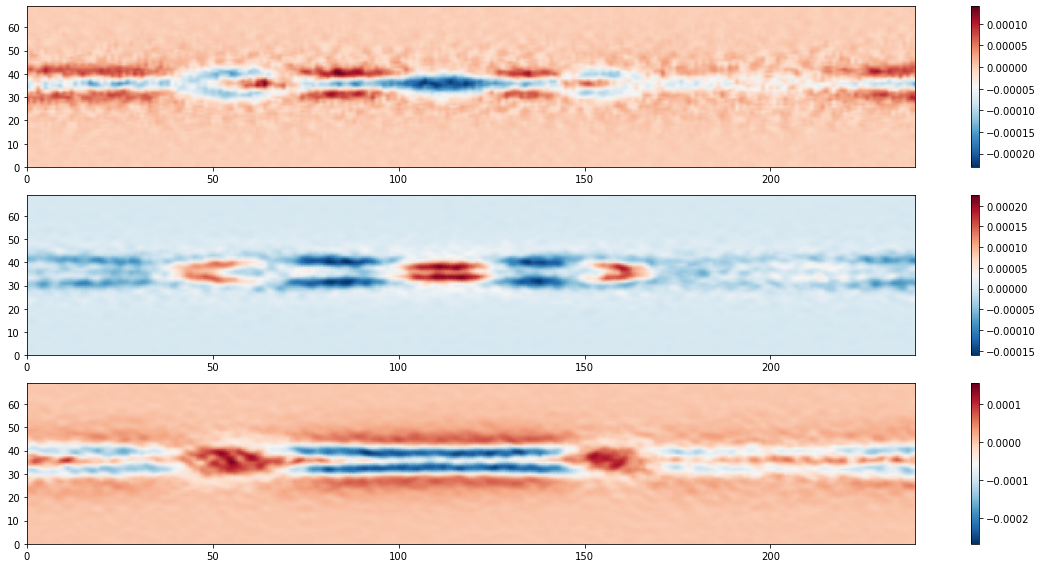

In [26]:
fig, axes = plt.subplots(3,1)
pcm0 = axes[0].pcolormesh(div_qxx, cmap='RdBu_r', shading='gouraud')
pcm1 = axes[1].pcolormesh(div_qyy, cmap='RdBu_r', shading='gouraud')
pcm2 = axes[2].pcolormesh(div_qzz, cmap='RdBu_r', shading='gouraud')
fig.colorbar(pcm0, ax=axes[0])
fig.colorbar(pcm1, ax=axes[1])
fig.colorbar(pcm2, ax=axes[2])
fig.tight_layout()

In [27]:
P_closure_xx = P_matrix_img[...,0,0] - P_avg
P_closure_yy = P_matrix_img[...,1,1] - P_avg
P_closure_zz = P_matrix_img[...,2,2] - P_avg
P_closure_x = np.stack((P_closure_xx.flatten(), Pxy_c, Pxz_c), -1)
P_closure_y = np.stack((Pxy_c, P_closure_yy.flatten(), Pyz_c), -1)
P_closure_z = np.stack((Pxz_c, Pyz_c, P_closure_zz.flatten()), -1)
P_closure = np.stack((P_closure_x, P_closure_y, P_closure_z), -1)

(3.3265112994192873e-16, True)

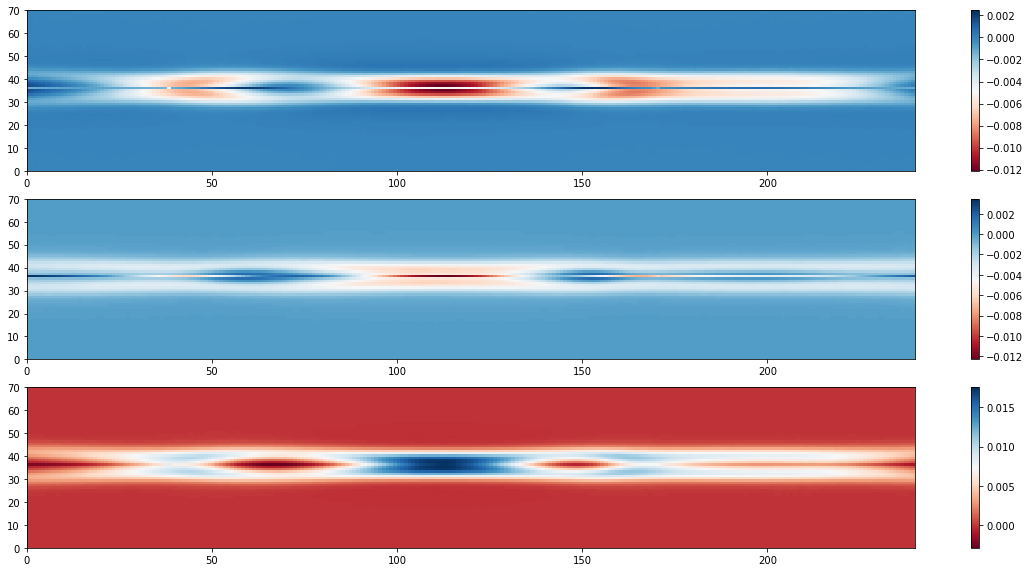

In [28]:
P_rot_avg = 1/3*(P_rotated[...,0,0] + P_rotated[...,1,1] + P_rotated[...,2,2])
P00_rotated = P_rotated[...,0,0] - P_rot_avg
P11_rotated = P_rotated[...,1,1] - P_rot_avg
P22_rotated = P_rotated[...,2,2] - P_rot_avg

P_closure_rotated_x = np.stack((P00_rotated, P_rotated[...,0,1], P_rotated[...,0,2]), -1)
P_closure_rotated_y = np.stack((P_rotated[...,1,0], P11_rotated, P_rotated[...,1,2]), -1)
P_closure_rotated_z = np.stack((P_rotated[...,2,0], P_rotated[...,2,1], P22_rotated), -1)
P_closure_rotated = np.stack((P_closure_rotated_x, P_closure_rotated_y, P_closure_rotated_z), -1)

P_closure_unrotated = B_matrix @ P_closure_rotated @ np.transpose(B_matrix, (0,2,1))

fig, axes = plt.subplots(3,1)
pcm0 = axes[0].pcolormesh(P_closure_rotated[...,0,0].reshape(zshape,xshape), cmap='RdBu')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(P_closure_rotated[...,1,1].reshape(zshape,xshape), cmap='RdBu')
fig.colorbar(pcm1, ax=axes[1])
pcm2 = axes[2].pcolormesh(P_closure_rotated[...,2,2].reshape(zshape,xshape), cmap='RdBu')
fig.colorbar(pcm2, ax=axes[2])
fig.tight_layout()
#does closure in xyz equal closure calcluated in rotated frame and rotated to xyz
np.linalg.norm(P_closure - P_closure_unrotated), np.allclose(P_closure, P_closure_unrotated)

In [29]:
#does closure calculated in rotated frame equal closure rotated from the xyz plane
P_rotated_from_xyz = np.transpose(B_matrix, (0,2,1)) @ P_closure @ B_matrix
np.allclose(P_rotated_from_xyz, P_closure_rotated)

True

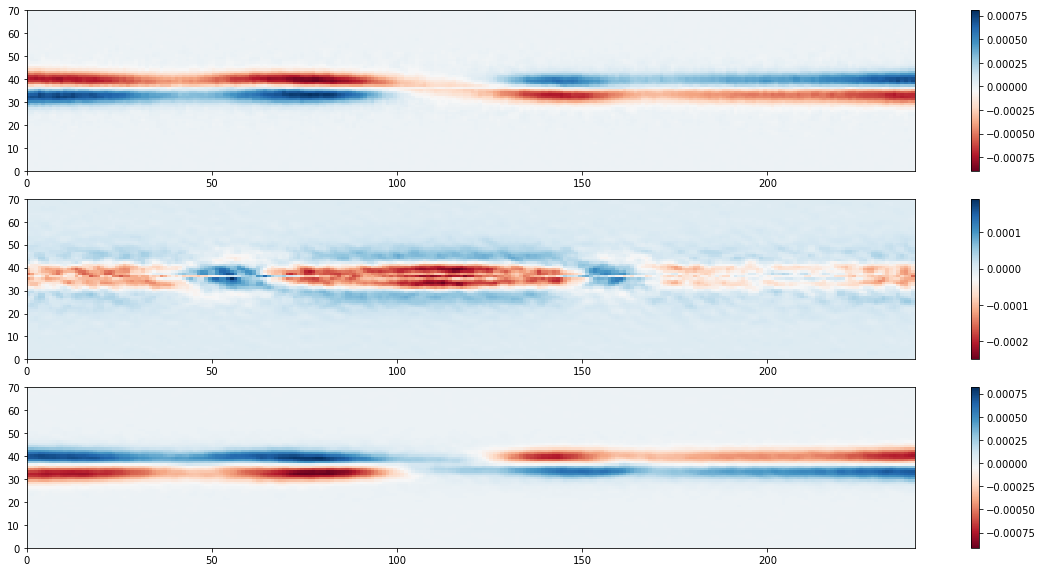

In [30]:
## Rotate everything into B_par B_perp1/2 directions 
## full resolution
div_qii_matrix_x = np.stack((div_qxx.flatten(), div_qxy.flatten(), div_qxz.flatten()), -1)
div_qii_matrix_y = np.stack((div_qxy.flatten(), div_qyy.flatten(), div_qyz.flatten()), -1)
div_qii_matrix_z = np.stack((div_qxz.flatten(), div_qyz.flatten(), div_qzz.flatten()), -1)
div_qii_matrix = np.stack((div_qii_matrix_x, div_qii_matrix_y, div_qii_matrix_z), -1)

div_qii_rotated = np.transpose(B_matrix, (0,2,1))@div_qii_matrix@B_matrix
div_qii_rotated_img = div_qii_rotated.reshape(zshape,xshape, 3, 3)

fig, axes = plt.subplots(3,1)
pcm0 = axes[0].pcolormesh(div_qii_rotated_img[...,0,0], cmap='RdBu')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(div_qii_rotated_img[...,1,1], cmap='RdBu')
fig.colorbar(pcm1, ax=axes[1])
pcm2 = axes[2].pcolormesh(div_qii_rotated_img[...,2,2], cmap='RdBu')
fig.colorbar(pcm2, ax=axes[2])
fig.tight_layout()

In [31]:
### Derivatives of Pressure Tensor ###

## how to get pressure derivatives in rotated frame?
d_pxx_c_dx = (np.diff(pxx_c, axis=1, prepend=0) + np.diff(pxx_c, axis=1, append=0))[cutz:-cutz,cutx:-cutx].flatten() / dx / 2
d_pxx_c_dz = (np.diff(pxx_c, axis=0, prepend=0) + np.diff(pxx_c, axis=0, append=0))[cutz:-cutz,cutx:-cutx].flatten() / dz / 2
d_pyy_c_dx = (np.diff(pyy_c, axis=1, prepend=0) + np.diff(pyy_c, axis=1, append=0))[cutz:-cutz,cutx:-cutx].flatten() / dx / 2
d_pyy_c_dz = (np.diff(pyy_c, axis=0, prepend=0) + np.diff(pyy_c, axis=0, append=0))[cutz:-cutz,cutx:-cutx].flatten() / dz / 2
d_pzz_c_dx = (np.diff(pzz_c, axis=1, prepend=0) + np.diff(pzz_c, axis=1, append=0))[cutz:-cutz,cutx:-cutx].flatten() / dx / 2
d_pzz_c_dz = (np.diff(pzz_c, axis=0, prepend=0) + np.diff(pzz_c, axis=0, append=0))[cutz:-cutz,cutx:-cutx].flatten() / dz / 2
d_pxy_c_dx = (np.diff(pxy_c, axis=1, prepend=0) + np.diff(pxy_c, axis=1, append=0))[cutz:-cutz,cutx:-cutx].flatten() / dx / 2
d_pxy_c_dz = (np.diff(pxy_c, axis=0, prepend=0) + np.diff(pxy_c, axis=0, append=0))[cutz:-cutz,cutx:-cutx].flatten() / dz / 2
d_pxz_c_dx = (np.diff(pxz_c, axis=1, prepend=0) + np.diff(pxz_c, axis=1, append=0))[cutz:-cutz,cutx:-cutx].flatten() / dx / 2
d_pxz_c_dz = (np.diff(pxz_c, axis=0, prepend=0) + np.diff(pxz_c, axis=0, append=0))[cutz:-cutz,cutx:-cutx].flatten() / dz / 2
d_pyz_c_dx = (np.diff(pyz_c, axis=1, prepend=0) + np.diff(pyz_c, axis=1, append=0))[cutz:-cutz,cutx:-cutx].flatten() / dx / 2
d_pyz_c_dz = (np.diff(pyz_c, axis=0, prepend=0) + np.diff(pyz_c, axis=0, append=0))[cutz:-cutz,cutx:-cutx].flatten() / dz / 2

d_P_dx_x = np.stack((d_pxx_c_dx, d_pxy_c_dx, d_pxz_c_dx), -1)
d_P_dx_y = np.stack((d_pxy_c_dx, d_pyy_c_dx, d_pyz_c_dx), -1)
d_P_dx_z = np.stack((d_pxz_c_dx, d_pyz_c_dx, d_pzz_c_dx), -1)
d_P_dx = np.stack((d_P_dx_x, d_P_dx_y, d_P_dx_z), -1)

d_P_dz_x = np.stack((d_pxx_c_dz, d_pxy_c_dz, d_pxz_c_dz), -1)
d_P_dz_y = np.stack((d_pxy_c_dz, d_pyy_c_dz, d_pyz_c_dz), -1)
d_P_dz_z = np.stack((d_pxz_c_dz, d_pyz_c_dz, d_pzz_c_dz), -1)
d_P_dz = np.stack((d_P_dz_x, d_P_dz_y, d_P_dz_z), -1)

d_P_rotated_dx = np.transpose(B_matrix, (0,2,1)) @ d_P_dx @ B_matrix
d_P_rotated_dz = np.transpose(B_matrix, (0,2,1)) @ d_P_dz @ B_matrix

In [32]:
### project mean velocity and derivatives into rotated frame ###
u = px_c[cutz:-cutz, cutx:-cutx].reshape(-1)
v = py_c[cutz:-cutz, cutx:-cutx].reshape(-1)
w = pz_c[cutz:-cutz, cutx:-cutx].reshape(-1)

mean_v = np.stack((u, v, w), -1)
v_par = np.sum(mean_v*B_par, -1)#.reshape(-1,1)*B_par
v_perp1 = np.sum(mean_v*B_perp1, -1)#.reshape(-1,1)#*B_perp1
v_perp2 = np.sum(mean_v*B_perp2, -1)#.reshape(-1,1)#*B_perp2

d_u_dx = (np.diff(px_c, axis=1, append=0) + np.diff(px_c, axis=1, append=0)) / dx / 2
d_u_dz = (np.diff(px_c, axis=0, append=0) + np.diff(px_c, axis=0, append=0)) / dz / 2
d_v_dx = (np.diff(py_c, axis=1, append=0) + np.diff(py_c, axis=1, append=0)) / dx / 2
d_v_dz = (np.diff(py_c, axis=0, append=0) + np.diff(py_c, axis=0, append=0)) / dz / 2
d_w_dx = (np.diff(pz_c, axis=1, append=0) + np.diff(pz_c, axis=1, append=0)) / dx / 2
d_w_dz = (np.diff(pz_c, axis=0, append=0) + np.diff(pz_c, axis=0, append=0)) / dz / 2
d_u_dx = d_u_dx[cutz:-cutz, cutx:-cutx].flatten()
d_u_dz = d_u_dz[cutz:-cutz, cutx:-cutx].flatten()
d_v_dx = d_v_dx[cutz:-cutz, cutx:-cutx].flatten()
d_v_dz = d_v_dz[cutz:-cutz, cutx:-cutx].flatten()
d_w_dx = d_w_dx[cutz:-cutz, cutx:-cutx].flatten()
d_w_dz = d_w_dz[cutz:-cutz, cutx:-cutx].flatten()

d_V_dx = np.stack((d_u_dx, d_v_dx, d_w_dx), -1)
d_v_dx_par = np.sum(d_V_dx*B_par, -1)#.reshape(-1,1)*B_par
d_v_dx_perp1 = np.sum(d_V_dx*B_perp1, -1)#.reshape(-1,1)*B_perp1
d_v_dx_perp2 = np.sum(d_V_dx*B_perp2, -1)#.reshape(-1,1)*B_perp2

d_V_dz = np.stack((d_u_dz, d_v_dz, d_w_dz), -1)
d_v_dz_par = np.sum(d_V_dz*B_par, -1)#.reshape(-1,1)*B_par
d_v_dz_perp1 = np.sum(d_V_dz*B_perp1, -1)#.reshape(-1,1)*B_perp1
d_v_dz_perp2 = np.sum(d_V_dz*B_perp2, -1)#.reshape(-1,1)*B_perp2

In [33]:

JE_matrix_x = np.stack((jx*Ex, jx*Ey, jx*Ez), -1)
JE_matrix_y = np.stack((jy*Ex, jy*Ey, jy*Ez), -1)
JE_matrix_z = np.stack((jz*Ex, jz*Ey, jz*Ez), -1)
JE_matrix = np.stack((JE_matrix_x, JE_matrix_y, JE_matrix_z), -1)
JE_rotated = np.transpose(B_matrix, (0,2,1)) @ JE_matrix @ B_matrix

closure_regressor = LstsqThresholdRegressor(lthreshold=0.1, uthreshold=1e2, scaling=False)

closure_library = np.vstack((
#                             vt*P_rotated[:,0,0],
#                             vt*P_rotated[:,1,1],
#                             vt*P_rotated[:,2,2],
#                               vt*P_closure_rotated[...,0,0],
#                               vt*P_closure_rotated[...,1,1],
#                               vt*P_closure_rotated[...,2,2],
#                             JE_rotated[:,0,0],
#                             JE_rotated[:,1,1],
#                             JE_rotated[:,2,2],
                        v_par*d_P_rotated_dx[...,0,0],
                        v_par*d_P_rotated_dz[...,0,0],
                        v_par*d_P_rotated_dx[...,1,1],
                        v_par*d_P_rotated_dz[...,1,1],
                        v_par*d_P_rotated_dx[...,2,2],
                        v_par*d_P_rotated_dz[...,2,2],
                        v_par*d_P_rotated_dx[...,0,1],
                        v_par*d_P_rotated_dz[...,0,1],
                        v_par*d_P_rotated_dx[...,0,2],
                        v_par*d_P_rotated_dz[...,0,2],
                        v_par*d_P_rotated_dx[...,1,2],
                        v_par*d_P_rotated_dz[...,1,2],
    
    
                        v_perp1*d_P_rotated_dx[...,0,0],
                        v_perp1*d_P_rotated_dz[...,0,0],
                        v_perp1*d_P_rotated_dx[...,1,1],
                        v_perp1*d_P_rotated_dz[...,1,1],
                        v_perp1*d_P_rotated_dx[...,2,2],
                        v_perp1*d_P_rotated_dz[...,2,2],
                        v_perp1*d_P_rotated_dx[...,0,1],
                        v_perp1*d_P_rotated_dz[...,0,1],
                        v_perp1*d_P_rotated_dx[...,0,2],
                        v_perp1*d_P_rotated_dz[...,0,2],
                        v_perp1*d_P_rotated_dx[...,1,2],
                        v_perp1*d_P_rotated_dz[...,1,2],
    
                        v_perp2*d_P_rotated_dx[...,0,0],
                        v_perp2*d_P_rotated_dz[...,0,0],
                        v_perp2*d_P_rotated_dx[...,1,1],
                        v_perp2*d_P_rotated_dz[...,1,1],
                        v_perp2*d_P_rotated_dx[...,2,2],
                        v_perp2*d_P_rotated_dz[...,2,2],
                        v_perp2*d_P_rotated_dx[...,0,1],
                        v_perp2*d_P_rotated_dz[...,0,1],
                        v_perp2*d_P_rotated_dx[...,0,2],
                        v_perp2*d_P_rotated_dz[...,0,2],
                        v_perp2*d_P_rotated_dx[...,1,2],
                        v_perp2*d_P_rotated_dz[...,1,2],

                        P_rotated[...,0,0]*d_v_dx_par,
                        P_rotated[...,0,0]*d_v_dz_par,
                        P_rotated[...,0,0]*d_v_dx_perp1,
                        P_rotated[...,0,0]*d_v_dz_perp1,
                        P_rotated[...,0,0]*d_v_dx_perp2,
                        P_rotated[...,0,0]*d_v_dz_perp2,
    
                        P_rotated[...,1,1]*d_v_dx_par,
                        P_rotated[...,1,1]*d_v_dz_par,
                        P_rotated[...,1,1]*d_v_dx_perp1,
                        P_rotated[...,1,1]*d_v_dz_perp1,
                        P_rotated[...,1,1]*d_v_dx_perp2,
                        P_rotated[...,1,1]*d_v_dz_perp2,
    
                        P_rotated[...,2,2]*d_v_dx_par,
                        P_rotated[...,2,2]*d_v_dz_par,
                        P_rotated[...,2,2]*d_v_dx_perp1,
                        P_rotated[...,2,2]*d_v_dz_perp1,
                        P_rotated[...,2,2]*d_v_dx_perp2,
                        P_rotated[...,2,2]*d_v_dz_perp2,
    
                        P_rotated[...,0,1]*d_v_dx_par,
                        P_rotated[...,0,1]*d_v_dz_par,
                        P_rotated[...,0,1]*d_v_dx_perp1,
                        P_rotated[...,0,1]*d_v_dz_perp1,
                        P_rotated[...,0,1]*d_v_dx_perp2,
                        P_rotated[...,0,1]*d_v_dz_perp2,
    
                        P_rotated[...,0,2]*d_v_dx_par,
                        P_rotated[...,0,2]*d_v_dz_par,
                        P_rotated[...,0,2]*d_v_dx_perp1,
                        P_rotated[...,0,2]*d_v_dz_perp1,
                        P_rotated[...,0,2]*d_v_dx_perp2,
                        P_rotated[...,0,2]*d_v_dz_perp2,
    
                        P_rotated[...,1,2]*d_v_dx_par,
                        P_rotated[...,1,2]*d_v_dz_par,
                        P_rotated[...,1,2]*d_v_dx_perp1,
                        P_rotated[...,1,2]*d_v_dz_perp1,
                        P_rotated[...,1,2]*d_v_dx_perp2,
                        P_rotated[...,1,2]*d_v_dz_perp2,
                    )).T
closure_library.shape

(16800, 72)

final SE:
	 [6.21239668e-05]
Weights:
	 Term 0: [3.32968267]
	 Term 1: [0.54700833]
	 Term 2: [-1.76339328]
	 Term 3: [-1.57115975]
	 Term 4: [1.2690703]
	 Term 5: [1.56475768]
	 Term 6: [-4.48235145]
	 Term 7: [18.18457725]
	 Term 8: [0.67799415]
	 Term 9: [0.39182186]
	 Term 10: [6.33894283]
	 Term 11: [11.28199148]
	 Term 12: [-3.83061143]
	 Term 13: [-9.64098368]
	 Term 14: [-2.44407513]
	 Term 15: [1.82473547]
	 Term 16: [-1.56040177]
	 Term 17: [1.42992704]
	 Term 18: [6.62446137]
	 Term 19: [-3.63331462]
	 Term 20: [7.78671064]
	 Term 21: [-8.87570842]
	 Term 22: [1.91135732]
	 Term 23: [-3.80277578]
	 Term 24: [0.43336385]
	 Term 25: [0.37085168]
	 Term 26: [-0.65006273]
	 Term 27: [-0.42338611]
	 Term 28: [-0.65212344]
	 Term 29: [0.]
	 Term 30: [-0.69006407]
	 Term 31: [-2.47464446]
	 Term 32: [-1.26183576]
	 Term 33: [0.20214459]
	 Term 34: [0.1076891]
	 Term 35: [0.]
	 Term 36: [-4.07701021]
	 Term 37: [-4.32779987]
	 Term 38: [-0.79792774]
	 Term 39: [2.90822339]
	 Term 40

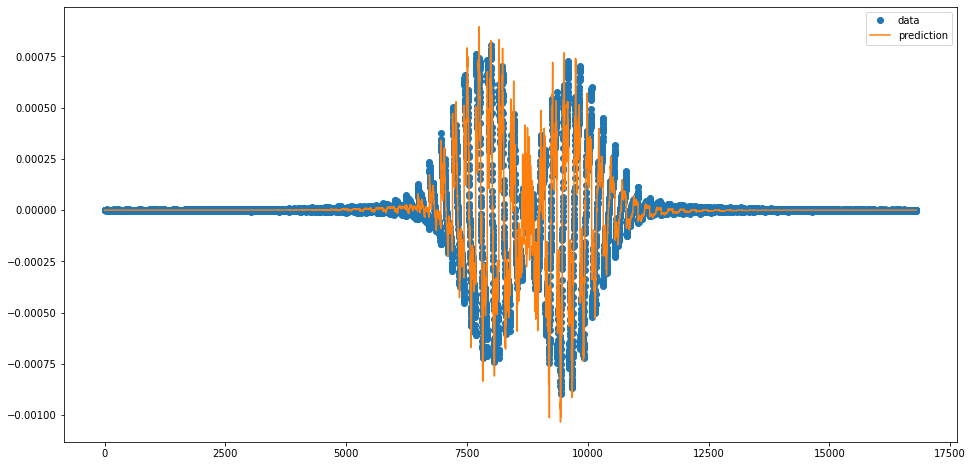

In [34]:
y = div_qii_rotated[...,0,0] 

closure_regressor.fit(closure_library, y)



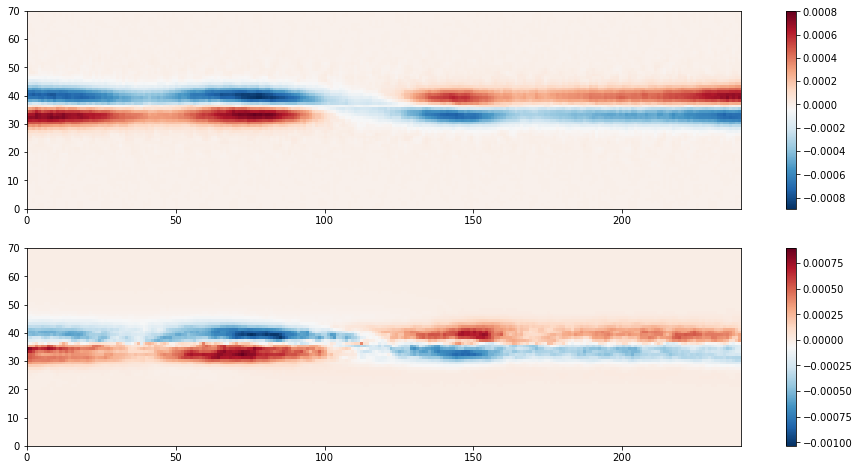

In [35]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qii_rotated_img[...,0,0], cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(zshape,xshape), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[1])

final SE:
	 [1.15919266e-05]
Weights:
	 Term 0: [0.41943814]
	 Term 1: [-0.60416245]
	 Term 2: [0.]
	 Term 3: [2.28816681]
	 Term 4: [-0.72982526]
	 Term 5: [-0.72984916]
	 Term 6: [3.9579475]
	 Term 7: [0.]
	 Term 8: [5.71333234]
	 Term 9: [0.]
	 Term 10: [0.2243418]
	 Term 11: [-0.70941792]
	 Term 12: [-2.23236957]
	 Term 13: [0.]
	 Term 14: [0.]
	 Term 15: [0.3764888]
	 Term 16: [-0.56844647]
	 Term 17: [0.]
	 Term 18: [-2.90762887]
	 Term 19: [-2.72551004]
	 Term 20: [-0.82231256]
	 Term 21: [1.19149565]
	 Term 22: [2.22080726]
	 Term 23: [0.]
	 Term 24: [-0.84702965]
	 Term 25: [0.]
	 Term 26: [0.]
	 Term 27: [0.]
	 Term 28: [-0.18390332]
	 Term 29: [0.]
	 Term 30: [0.]
	 Term 31: [0.61176714]
	 Term 32: [-0.42595644]
	 Term 33: [0.]
	 Term 34: [0.]
	 Term 35: [0.]
	 Term 36: [4.36468174]
	 Term 37: [-0.30365276]
	 Term 38: [0.45059236]
	 Term 39: [1.71740126]
	 Term 40: [1.61106751]
	 Term 41: [0.]
	 Term 42: [-2.49934783]
	 Term 43: [0.]
	 Term 44: [-0.23343057]
	 Term 45: [0.]


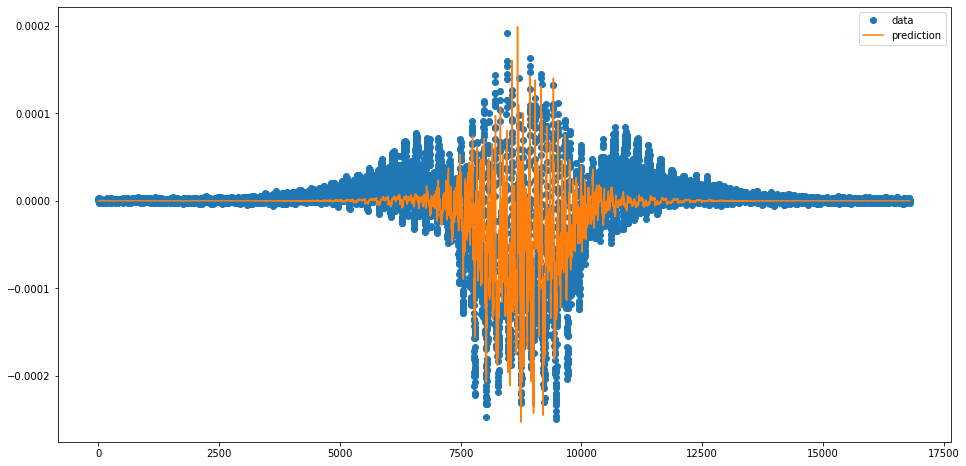

In [36]:
y = div_qii_rotated[...,1,1] 

closure_regressor.fit(closure_library, y)


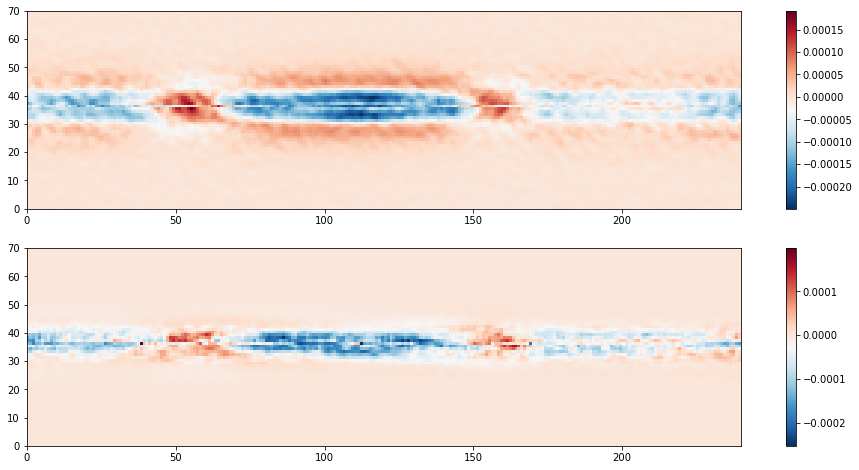

In [37]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qii_rotated_img[...,1,1], cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(zshape,xshape), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[1])

final SE:
	 [6.82821889e-05]
Weights:
	 Term 0: [-3.93599859]
	 Term 1: [-0.33030999]
	 Term 2: [0.74203435]
	 Term 3: [2.35058608]
	 Term 4: [-1.72379608]
	 Term 5: [-2.04176749]
	 Term 6: [1.47373886]
	 Term 7: [-15.02281542]
	 Term 8: [2.94274111]
	 Term 9: [0.]
	 Term 10: [-6.33534691]
	 Term 11: [-12.65228064]
	 Term 12: [1.36635403]
	 Term 13: [9.61973029]
	 Term 14: [1.29894622]
	 Term 15: [-1.99601163]
	 Term 16: [0.]
	 Term 17: [-1.0216401]
	 Term 18: [-7.23418314]
	 Term 19: [7.0464587]
	 Term 20: [-9.5730345]
	 Term 21: [10.63335155]
	 Term 22: [-2.17140681]
	 Term 23: [5.27993734]
	 Term 24: [-1.23578217]
	 Term 25: [-0.20948271]
	 Term 26: [0.50943553]
	 Term 27: [0.41479296]
	 Term 28: [0.65286587]
	 Term 29: [0.]
	 Term 30: [0.64448694]
	 Term 31: [3.25632771]
	 Term 32: [0.94626471]
	 Term 33: [-0.13761208]
	 Term 34: [0.14198815]
	 Term 35: [0.22118547]
	 Term 36: [3.30089769]
	 Term 37: [3.59956277]
	 Term 38: [2.05020465]
	 Term 39: [-1.96305755]
	 Term 40: [2.882609

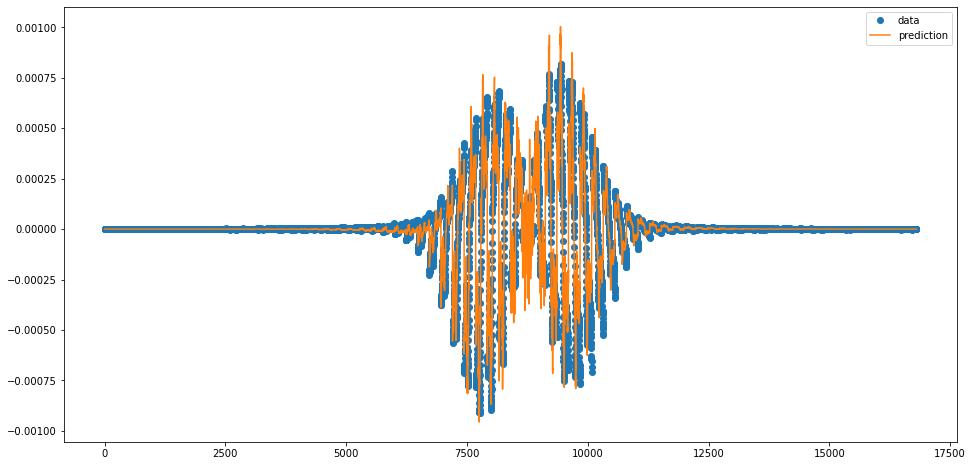

In [38]:
y = div_qii_rotated[...,2,2] 

closure_regressor.fit(closure_library, y)


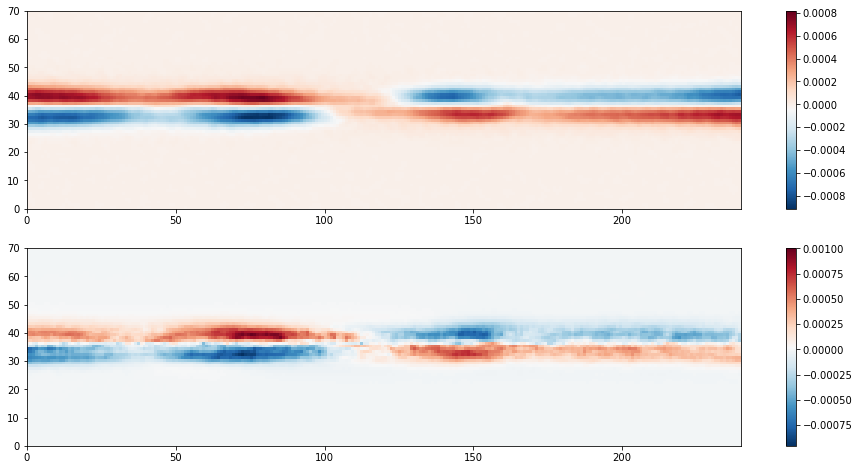

In [39]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qii_rotated_img[...,2,2], cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(zshape,xshape), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[1])